In [1]:
import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)

/home/team4/anaconda3/envs/gpu/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/team4/anaconda3/envs/gpu/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/team4/anaconda3/envs/gpu/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/team4/anaconda3/envs/gpu/lib/python3.7/site-packages

In [2]:
import keras
import pandas as pd
import tensorflow as tf

import numpy as np
# from keras.models import Sequential, Model
# from keras.layers import Dense, Dropout, Activation, Flatten, Convolution2D, MaxPooling2D, GlobalAveragePooling2D
from keras.utils import np_utils

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Convolution2D, MaxPooling2D, GlobalAveragePooling2D, Input,AveragePooling2D, BatchNormalization, LeakyReLU

# from keras.applications import MobileNet
# from keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2, InceptionV3
from tensorflow.keras.optimizers import Adam

from matplotlib import pyplot as plt
import os
from sklearn.model_selection import train_test_split

import seaborn as sns
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.model_selection import KFold

from collections import defaultdict,Counter
from imblearn.over_sampling import SMOTE
from PIL import Image

from kerastuner import HyperModel

Using TensorFlow backend.


<h2>Data Loading and Preparation</h2>

In [3]:
def getSpeciesCode(x):
    part = x.split('_')
    if part[0] == 'ASETRI':
        return 0
    elif part[0] == 'EPTBOT':
        return 1
    elif part[0] == 'MYOEMA':
        return 2
    elif part[0] == 'PIPKUH':
        return 3
    elif part[0] == 'RHIMUS':
        return 4
    elif part[0] == 'RHYNAS':
        return 5
    elif part[0] == 'ROUAEG':
        return 6
    elif part[0] == 'TAPPER':
        return 7
    else:
        return 'Unknown'
    
def getSpecies(x):
    if x == 0:
        return 'A.tridens'
    elif x == 1:
        return 'E.bottae'
    elif x == 2:
        return 'M.emarginatus'
    elif x == 3:
        return 'P.kuhli'
    elif x == 4:
        return 'R.muscatellum'
    elif x == 5:
        return 'R.nasutus'
    elif x == 6:
        return 'R.aegyptius'
    elif x == 7:
        return 'T.perforatus'
    else:
        return 'Unknown'
    
    
def generate_actual_predicted(Y_pred, X_test, Y_test): 
    predicted = list()
    for i in range(len(Y_pred)):
        predicted.append(np.argmax(Y_pred[i]))
        
    actual = list()
    for i in range(len(Y_test)):
        actual.append(np.argmax(Y_test[i]))
        
    return actual, predicted

In [4]:
image_folder_path = '../data/refspec'
file_paths = [f for f in os.listdir(image_folder_path)]
species = []
for file_name in file_paths:
    sp = file_name.split('_')
    species.append(sp[0])

df = pd.DataFrame(species, columns=['Species'])
df['Species'].value_counts()

RHIMUS    1665
TAPPER     403
PIPKUH     299
RHYNAS     269
EPTBOT     124
ROUAEG     121
MYOEMA     112
ASETRI      25
Name: Species, dtype: int64

In [5]:
X_all = []
Y_all = []

image_folder_path = '../data/refspec'
file_paths = [f for f in os.listdir(image_folder_path)]

for file_name in file_paths:
    spectrogram = Image.open(image_folder_path + '/' + file_name)
    spectrogram = spectrogram.convert('RGB')
    spectrogram = spectrogram.resize((170, 112))  
    spectrogram = np.array(spectrogram)
    #spectrogram = np.expand_dims(spectrogram, axis=2) 
    X_all.append(spectrogram)
    Y_all.append(getSpeciesCode(file_name))


In [6]:
X_all = np.array(X_all)
Y_all = np.array(Y_all)

print(X_all.shape)
print(Y_all.shape)

X_all = X_all.astype('float32')
X_all /= 255

Y_all = np_utils.to_categorical(Y_all, num_classes=8) 


(3018, 112, 170, 3)
(3018,)


In [7]:
# train /test= 80/20% split
# Data is stratified
X_train, X_test, Y_train, Y_test = train_test_split(X_all, Y_all, test_size=0.2, random_state = 245, stratify=Y_all)


<h2>Keras Tuner</h2>

In [8]:
class CNNHyperModel(HyperModel):
    def __init__(self, input_shape, num_classes):
        self.input_shape = input_shape
        self.num_classes = num_classes

    def build(self, hp):        
        inp = Input(shape=self.input_shape)
        c1 = Convolution2D(filters=hp.Int('conv1',
                                 min_value=8,
                                 max_value=128,
                                 step=16,
                                 default=64),kernel_size=(7,7),strides=(2,2),padding='same')(inp)
        bt = BatchNormalization()(c1)
        bt = Activation('relu')(bt)
        mpool = MaxPooling2D(pool_size=(2,2),strides=2,padding='same')(bt)
        mpool = Dropout(0.2)(mpool)


        c2 = Convolution2D(filters=hp.Int('conv2',
                                 min_value=8,
                                 max_value=128,
                                 step=16,
                                 default=64),kernel_size=(5,5),strides=(2,2),padding='same')(mpool)
        bt = BatchNormalization()(c2)
        bt = Activation('relu')(bt)
        #bt = LeakyReLU(alpha=0.01)(bt)
        mpool = AveragePooling2D(pool_size=(2,2),strides=2,padding='same')(bt)
        mpool = Dropout(0.3)(mpool)

        c2 = Convolution2D(filters=hp.Int('conv3',
                                 min_value=8,
                                 max_value=128,
                                 step=16,
                                 default=64),kernel_size=(3,3),strides=(1,1),padding='same')(mpool)
        bt = BatchNormalization()(c2)
        bt = Activation('relu')(bt)
        #bt = LeakyReLU(alpha=0.01)(bt)
        mpool = AveragePooling2D(pool_size=(2,2),strides=2,padding='same')(bt)
        mpool = Dropout(rate=0.3)(mpool)

        c3 = Convolution2D(filters=hp.Int('conv4',
                                 min_value=8,
                                 max_value=128,
                                 step=16,
                                 default=64),kernel_size=(3,3),strides=(1,1),padding='same')(mpool)
        bt = BatchNormalization()(c3)
        bt = Activation('relu')(bt)
        #bt = LeakyReLU(alpha=0.01)(bt)
        mpool = AveragePooling2D(pool_size=(2,2),strides=2,padding='same')(bt)
        mpool = Dropout(rate=0.4)(mpool)

        f = Flatten()(mpool)

        x_dense = Dense(256)(f)
        bt = BatchNormalization()(x_dense)
        bt = Activation('relu')(bt)
        bt = Dropout(0.4)(bt)


        x_dense = Dense(128)(bt)
        bt = BatchNormalization()(x_dense)
        bt = Activation('relu')(bt)
        bt = Dropout(0.3)(bt)

        x_dense = Dense(64)(bt)
        bt = BatchNormalization()(x_dense)
        bt = Activation('relu')(bt)
        bt = Dropout(0.2)(bt)

        x_out = Dense(8, name='output', activation='softmax')(bt)
        model = Model(inputs=inp, outputs=x_out)
        model.compile(
            optimizer=Adam(lr=0.003),
            loss='categorical_crossentropy',
            metrics=['accuracy']
        )
        return model

In [24]:
from kerastuner.tuners import RandomSearch

hypermodel = CNNHyperModel(input_shape=(112,170,3), num_classes=8)

tuner = RandomSearch(
    hypermodel,
    objective='val_acc',
    seed=1,
    max_trials=5,
    executions_per_trial=2,
    directory='random_search',
    project_name='bat',
    overwrite=True
)

In [25]:
tuner.search(X_train, Y_train, epochs=70, validation_split=0.1, batch_size=8, verbose=2)

Train on 2172 samples, validate on 242 samples
Epoch 1/70
2172/2172 - 3s - loss: 1.5801 - acc: 0.4908 - val_loss: 1.8514 - val_acc: 0.4545
Epoch 2/70
2172/2172 - 2s - loss: 1.3581 - acc: 0.5608 - val_loss: 1.3437 - val_acc: 0.5744
Epoch 3/70
2172/2172 - 3s - loss: 1.3156 - acc: 0.5792 - val_loss: 1.4030 - val_acc: 0.5331
Epoch 4/70
2172/2172 - 2s - loss: 1.2314 - acc: 0.5824 - val_loss: 1.2603 - val_acc: 0.5496
Epoch 5/70
2172/2172 - 2s - loss: 1.1416 - acc: 0.6105 - val_loss: 1.0018 - val_acc: 0.6983
Epoch 6/70
2172/2172 - 2s - loss: 0.9996 - acc: 0.6593 - val_loss: 0.9858 - val_acc: 0.6736
Epoch 7/70
2172/2172 - 2s - loss: 0.9524 - acc: 0.6717 - val_loss: 0.7249 - val_acc: 0.7438
Epoch 8/70
2172/2172 - 2s - loss: 0.9070 - acc: 0.7049 - val_loss: 0.6169 - val_acc: 0.7934
Epoch 9/70
2172/2172 - 2s - loss: 0.8466 - acc: 0.7261 - val_loss: 0.6526 - val_acc: 0.7645
Epoch 10/70
2172/2172 - 2s - loss: 0.8510 - acc: 0.7210 - val_loss: 0.7193 - val_acc: 0.7521
Epoch 11/70
2172/2172 - 2s - los

Epoch 19/70
2172/2172 - 2s - loss: 0.5861 - acc: 0.8149 - val_loss: 0.3685 - val_acc: 0.8760
Epoch 20/70
2172/2172 - 2s - loss: 0.5378 - acc: 0.8283 - val_loss: 0.3734 - val_acc: 0.8719
Epoch 21/70
2172/2172 - 2s - loss: 0.5134 - acc: 0.8407 - val_loss: 0.5305 - val_acc: 0.8099
Epoch 22/70
2172/2172 - 2s - loss: 0.4909 - acc: 0.8435 - val_loss: 0.4002 - val_acc: 0.8719
Epoch 23/70
2172/2172 - 2s - loss: 0.4813 - acc: 0.8476 - val_loss: 0.3135 - val_acc: 0.8926
Epoch 24/70
2172/2172 - 2s - loss: 0.4287 - acc: 0.8665 - val_loss: 0.3445 - val_acc: 0.8719
Epoch 25/70
2172/2172 - 2s - loss: 0.4633 - acc: 0.8471 - val_loss: 0.3281 - val_acc: 0.8926
Epoch 26/70
2172/2172 - 2s - loss: 0.4329 - acc: 0.8623 - val_loss: 0.3757 - val_acc: 0.8678
Epoch 27/70
2172/2172 - 2s - loss: 0.4603 - acc: 0.8568 - val_loss: 0.2576 - val_acc: 0.9132
Epoch 28/70
2172/2172 - 2s - loss: 0.4104 - acc: 0.8697 - val_loss: 0.3407 - val_acc: 0.8802
Epoch 29/70
2172/2172 - 2s - loss: 0.4165 - acc: 0.8766 - val_loss: 0.

Train on 2172 samples, validate on 242 samples
Epoch 1/70
2172/2172 - 3s - loss: 1.5446 - acc: 0.5069 - val_loss: 1.7894 - val_acc: 0.4298
Epoch 2/70
2172/2172 - 2s - loss: 1.3998 - acc: 0.5479 - val_loss: 1.2457 - val_acc: 0.5992
Epoch 3/70
2172/2172 - 2s - loss: 1.3205 - acc: 0.5691 - val_loss: 1.1567 - val_acc: 0.6281
Epoch 4/70
2172/2172 - 2s - loss: 1.2607 - acc: 0.5856 - val_loss: 1.1242 - val_acc: 0.6529
Epoch 5/70
2172/2172 - 2s - loss: 1.1744 - acc: 0.6100 - val_loss: 0.9165 - val_acc: 0.6942
Epoch 6/70
2172/2172 - 3s - loss: 1.0763 - acc: 0.6358 - val_loss: 0.8115 - val_acc: 0.7273
Epoch 7/70
2172/2172 - 2s - loss: 0.9872 - acc: 0.6634 - val_loss: 0.9499 - val_acc: 0.6612
Epoch 8/70
2172/2172 - 2s - loss: 0.9577 - acc: 0.6750 - val_loss: 0.7771 - val_acc: 0.7521
Epoch 9/70
2172/2172 - 2s - loss: 0.8969 - acc: 0.7030 - val_loss: 0.6341 - val_acc: 0.8017
Epoch 10/70
2172/2172 - 2s - loss: 0.8547 - acc: 0.7274 - val_loss: 0.6048 - val_acc: 0.8058
Epoch 11/70
2172/2172 - 2s - los

Epoch 19/70
2172/2172 - 3s - loss: 0.5475 - acc: 0.8287 - val_loss: 0.3144 - val_acc: 0.8843
Epoch 20/70
2172/2172 - 2s - loss: 0.5244 - acc: 0.8398 - val_loss: 0.5094 - val_acc: 0.8347
Epoch 21/70
2172/2172 - 3s - loss: 0.4993 - acc: 0.8292 - val_loss: 0.7304 - val_acc: 0.7562
Epoch 22/70
2172/2172 - 3s - loss: 0.5167 - acc: 0.8361 - val_loss: 0.3191 - val_acc: 0.9091
Epoch 23/70
2172/2172 - 3s - loss: 0.4838 - acc: 0.8421 - val_loss: 0.3370 - val_acc: 0.8636
Epoch 24/70
2172/2172 - 3s - loss: 0.4478 - acc: 0.8550 - val_loss: 0.3499 - val_acc: 0.8884
Epoch 25/70
2172/2172 - 3s - loss: 0.4213 - acc: 0.8683 - val_loss: 0.2551 - val_acc: 0.9215
Epoch 26/70
2172/2172 - 2s - loss: 0.4403 - acc: 0.8628 - val_loss: 0.2679 - val_acc: 0.9256
Epoch 27/70
2172/2172 - 3s - loss: 0.4507 - acc: 0.8642 - val_loss: 0.3071 - val_acc: 0.8926
Epoch 28/70
2172/2172 - 3s - loss: 0.4071 - acc: 0.8729 - val_loss: 0.3152 - val_acc: 0.8926
Epoch 29/70
2172/2172 - 3s - loss: 0.4068 - acc: 0.8752 - val_loss: 0.

Train on 2172 samples, validate on 242 samples
Epoch 1/70
2172/2172 - 3s - loss: 1.5575 - acc: 0.5018 - val_loss: 1.3492 - val_acc: 0.5537
Epoch 2/70
2172/2172 - 2s - loss: 1.3824 - acc: 0.5529 - val_loss: 2.1477 - val_acc: 0.4298
Epoch 3/70
2172/2172 - 2s - loss: 1.3043 - acc: 0.5783 - val_loss: 1.4077 - val_acc: 0.6529
Epoch 4/70
2172/2172 - 2s - loss: 1.2493 - acc: 0.6050 - val_loss: 1.0778 - val_acc: 0.6529
Epoch 5/70
2172/2172 - 2s - loss: 1.2243 - acc: 0.6050 - val_loss: 0.9817 - val_acc: 0.6736
Epoch 6/70
2172/2172 - 2s - loss: 1.0805 - acc: 0.6404 - val_loss: 0.9051 - val_acc: 0.6860
Epoch 7/70
2172/2172 - 2s - loss: 1.0273 - acc: 0.6556 - val_loss: 0.9758 - val_acc: 0.7149
Epoch 8/70
2172/2172 - 2s - loss: 0.9335 - acc: 0.6713 - val_loss: 0.7788 - val_acc: 0.7314
Epoch 9/70
2172/2172 - 2s - loss: 0.9186 - acc: 0.6906 - val_loss: 1.4058 - val_acc: 0.5868
Epoch 10/70
2172/2172 - 2s - loss: 0.8740 - acc: 0.7155 - val_loss: 0.6936 - val_acc: 0.7686
Epoch 11/70
2172/2172 - 2s - los

Epoch 19/70
2172/2172 - 2s - loss: 0.4940 - acc: 0.8416 - val_loss: 0.2887 - val_acc: 0.9050
Epoch 20/70
2172/2172 - 3s - loss: 0.4752 - acc: 0.8439 - val_loss: 0.3430 - val_acc: 0.8760
Epoch 21/70
2172/2172 - 2s - loss: 0.4334 - acc: 0.8559 - val_loss: 0.2638 - val_acc: 0.9174
Epoch 22/70
2172/2172 - 3s - loss: 0.4671 - acc: 0.8536 - val_loss: 0.3103 - val_acc: 0.8884
Epoch 23/70
2172/2172 - 3s - loss: 0.4405 - acc: 0.8605 - val_loss: 0.6406 - val_acc: 0.8099
Epoch 24/70
2172/2172 - 2s - loss: 0.4135 - acc: 0.8729 - val_loss: 0.2161 - val_acc: 0.9215
Epoch 25/70
2172/2172 - 3s - loss: 0.3909 - acc: 0.8780 - val_loss: 0.2211 - val_acc: 0.9174
Epoch 26/70
2172/2172 - 3s - loss: 0.3582 - acc: 0.8840 - val_loss: 0.2575 - val_acc: 0.8926
Epoch 27/70
2172/2172 - 3s - loss: 0.3983 - acc: 0.8757 - val_loss: 0.2283 - val_acc: 0.9091
Epoch 28/70
2172/2172 - 3s - loss: 0.3629 - acc: 0.8849 - val_loss: 0.2165 - val_acc: 0.9256
Epoch 29/70
2172/2172 - 2s - loss: 0.3373 - acc: 0.8890 - val_loss: 0.

2172/2172 - 2s - loss: 0.2441 - acc: 0.9240 - val_loss: 0.1699 - val_acc: 0.9463
Epoch 57/70
2172/2172 - 2s - loss: 0.2000 - acc: 0.9374 - val_loss: 0.1375 - val_acc: 0.9545
Epoch 58/70
2172/2172 - 2s - loss: 0.2668 - acc: 0.9199 - val_loss: 0.3466 - val_acc: 0.8967
Epoch 59/70
2172/2172 - 2s - loss: 0.2276 - acc: 0.9268 - val_loss: 0.1671 - val_acc: 0.9587
Epoch 60/70
2172/2172 - 2s - loss: 0.2571 - acc: 0.9213 - val_loss: 0.1930 - val_acc: 0.9504
Epoch 61/70
2172/2172 - 2s - loss: 0.1762 - acc: 0.9438 - val_loss: 0.1433 - val_acc: 0.9587
Epoch 62/70
2172/2172 - 2s - loss: 0.2460 - acc: 0.9309 - val_loss: 0.1542 - val_acc: 0.9463
Epoch 63/70
2172/2172 - 2s - loss: 0.1956 - acc: 0.9346 - val_loss: 0.1568 - val_acc: 0.9463
Epoch 64/70
2172/2172 - 2s - loss: 0.2349 - acc: 0.9300 - val_loss: 0.1459 - val_acc: 0.9421
Epoch 65/70
2172/2172 - 2s - loss: 0.2018 - acc: 0.9392 - val_loss: 0.1815 - val_acc: 0.9339
Epoch 66/70
2172/2172 - 2s - loss: 0.2052 - acc: 0.9369 - val_loss: 0.1103 - val_a

Train on 2172 samples, validate on 242 samples
Epoch 1/70
2172/2172 - 3s - loss: 1.5478 - acc: 0.5023 - val_loss: 1.4353 - val_acc: 0.5124
Epoch 2/70
2172/2172 - 2s - loss: 1.3536 - acc: 0.5493 - val_loss: 1.1669 - val_acc: 0.5992
Epoch 3/70
2172/2172 - 2s - loss: 1.2722 - acc: 0.5852 - val_loss: 1.0835 - val_acc: 0.6446
Epoch 4/70
2172/2172 - 2s - loss: 1.2222 - acc: 0.5893 - val_loss: 1.0913 - val_acc: 0.6322
Epoch 5/70
2172/2172 - 2s - loss: 1.1163 - acc: 0.6266 - val_loss: 1.0414 - val_acc: 0.6818
Epoch 6/70
2172/2172 - 2s - loss: 1.0091 - acc: 0.6625 - val_loss: 0.9342 - val_acc: 0.6488
Epoch 7/70
2172/2172 - 2s - loss: 0.9751 - acc: 0.6727 - val_loss: 0.9229 - val_acc: 0.7231
Epoch 8/70
2172/2172 - 2s - loss: 0.8855 - acc: 0.7063 - val_loss: 0.7109 - val_acc: 0.7479
Epoch 9/70
2172/2172 - 2s - loss: 0.8780 - acc: 0.7086 - val_loss: 0.6589 - val_acc: 0.7645
Epoch 10/70
2172/2172 - 2s - loss: 0.8016 - acc: 0.7394 - val_loss: 0.6236 - val_acc: 0.7851
Epoch 11/70
2172/2172 - 2s - los

Epoch 19/70
2172/2172 - 2s - loss: 0.5637 - acc: 0.8218 - val_loss: 0.3671 - val_acc: 0.8636
Epoch 20/70
2172/2172 - 2s - loss: 0.5533 - acc: 0.8278 - val_loss: 0.3887 - val_acc: 0.8636
Epoch 21/70
2172/2172 - 2s - loss: 0.5246 - acc: 0.8278 - val_loss: 0.4198 - val_acc: 0.8554
Epoch 22/70
2172/2172 - 2s - loss: 0.4829 - acc: 0.8435 - val_loss: 0.3016 - val_acc: 0.8802
Epoch 23/70
2172/2172 - 2s - loss: 0.4946 - acc: 0.8402 - val_loss: 0.2920 - val_acc: 0.8967
Epoch 24/70
2172/2172 - 2s - loss: 0.4875 - acc: 0.8448 - val_loss: 0.3173 - val_acc: 0.8843
Epoch 25/70
2172/2172 - 2s - loss: 0.4745 - acc: 0.8513 - val_loss: 0.4158 - val_acc: 0.8719
Epoch 26/70
2172/2172 - 2s - loss: 0.4153 - acc: 0.8679 - val_loss: 0.2841 - val_acc: 0.8926
Epoch 27/70
2172/2172 - 2s - loss: 0.4424 - acc: 0.8642 - val_loss: 0.3682 - val_acc: 0.8719
Epoch 28/70
2172/2172 - 2s - loss: 0.3882 - acc: 0.8711 - val_loss: 0.2261 - val_acc: 0.9091
Epoch 29/70
2172/2172 - 2s - loss: 0.4417 - acc: 0.8651 - val_loss: 0.

INFO:tensorflow:Oracle triggered exit


In [26]:
tuner.results_summary()

In [27]:
best_model = tuner.get_best_models(num_models=1)[0]
loss, accuracy = best_model.evaluate(X_test, Y_test)

604/604 [==============================] - ETA: 2s - loss: 0.0453 - acc: 1.000 - ETA: 0s - loss: 0.1390 - acc: 0.959 - ETA: 0s - loss: 0.1158 - acc: 0.963 - 0s 448us/sample - loss: 0.1119 - acc: 0.9652


In [28]:
accuracy

0.9652318

<h2>Evaluate Best Model</h2>

In [29]:
model = best_model

[[  4   0   0   0   1   0   0   0]
 [  0  24   1   0   0   0   0   0]
 [  0   0  20   0   0   0   1   1]
 [  0   1   0  57   0   1   0   1]
 [  0   0   0   0 330   0   0   3]
 [  0   1   0   2   0  50   1   0]
 [  0   0   0   0   2   0  22   0]
 [  0   0   0   0   4   0   1  76]]


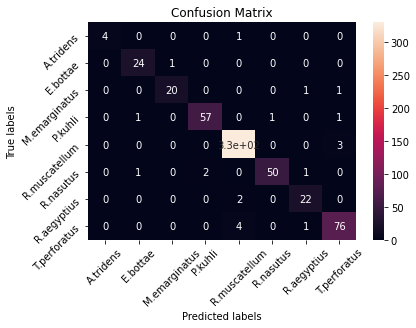

In [30]:
Y_pred = model.predict(X_test)
actual, predicted = generate_actual_predicted(Y_pred, X_test, Y_test)

##Confusion Matrix
from sklearn.metrics import confusion_matrix
actual_labeled = list()
predict_labeled = list()
for x,y in zip(actual,predicted):
    actual_labeled.append(getSpecies(x))
    predict_labeled.append(getSpecies(y))

labels = ['A.tridens','E.bottae','M.emarginatus','P.kuhli','R.muscatellum','R.nasutus', 'R.aegyptius', 'T.perforatus']
cm=confusion_matrix(actual_labeled,predict_labeled,labels=labels)
print(cm)

ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(labels,rotation=45); ax.yaxis.set_ticklabels(labels,rotation=45);

In [31]:
## Test accuracy
from sklearn.metrics import accuracy_score
print('accuracy', accuracy_score(actual, predicted))


accuracy 0.9652317880794702


In [32]:
## Precision, Recall, F1, Support
from sklearn.metrics import classification_report
print(classification_report(actual_labeled, predict_labeled,labels=labels))

               precision    recall  f1-score   support

    A.tridens       1.00      0.80      0.89         5
     E.bottae       0.92      0.96      0.94        25
M.emarginatus       0.95      0.91      0.93        22
      P.kuhli       0.97      0.95      0.96        60
R.muscatellum       0.98      0.99      0.99       333
    R.nasutus       0.98      0.93      0.95        54
  R.aegyptius       0.88      0.92      0.90        24
 T.perforatus       0.94      0.94      0.94        81

     accuracy                           0.97       604
    macro avg       0.95      0.92      0.94       604
 weighted avg       0.97      0.97      0.97       604



<h2>K-Fold Training and Evaluation</h2>

In [34]:
def build_current_model():
    inp = Input(shape=(112,170,3))
    c1 = Convolution2D(filters=56,kernel_size=(7,7),strides=(2,2),padding='same')(inp)
    bt = BatchNormalization()(c1)
    bt = Activation('relu')(bt)
    mpool = MaxPooling2D(pool_size=(2,2),strides=2,padding='same')(bt)
    mpool = Dropout(0.2)(mpool)


    c2 = Convolution2D(filters=72,kernel_size=(5,5),strides=(2,2),padding='same')(mpool)
    bt = BatchNormalization()(c2)
    bt = Activation('relu')(bt)
    #bt = LeakyReLU(alpha=0.01)(bt)
    mpool = AveragePooling2D(pool_size=(2,2),strides=2,padding='same')(bt)
    mpool = Dropout(0.3)(mpool)

    c2 = Convolution2D(filters=56,kernel_size=(3,3),strides=(1,1),padding='same')(mpool)
    bt = BatchNormalization()(c2)
    bt = Activation('relu')(bt)
    #bt = LeakyReLU(alpha=0.01)(bt)
    mpool = AveragePooling2D(pool_size=(2,2),strides=2,padding='same')(bt)
    mpool = Dropout(rate=0.3)(mpool)

    c3 = Convolution2D(filters=72,kernel_size=(3,3),strides=(1,1),padding='same')(mpool)
    bt = BatchNormalization()(c3)
    bt = Activation('relu')(bt)
    #bt = LeakyReLU(alpha=0.01)(bt)
    mpool = AveragePooling2D(pool_size=(2,2),strides=2,padding='same')(bt)
    mpool = Dropout(rate=0.4)(mpool)

    f = Flatten()(mpool)

    x_dense = Dense(256)(f)
    bt = BatchNormalization()(x_dense)
    bt = Activation('relu')(bt)
    bt = Dropout(0.4)(bt)


    x_dense = Dense(128)(bt)
    bt = BatchNormalization()(x_dense)
    bt = Activation('relu')(bt)
    bt = Dropout(0.3)(bt)

    x_dense = Dense(64)(bt)
    bt = BatchNormalization()(x_dense)
    bt = Activation('relu')(bt)
    bt = Dropout(0.2)(bt)

    x_out = Dense(8, name='output', activation='softmax')(bt)
    model = Model(inputs=inp, outputs=x_out)
    model.compile(
        optimizer=Adam(lr=0.003),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model


In [35]:
model = build_current_model()
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 112, 170, 3)]     0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 56, 85, 56)        8288      
_________________________________________________________________
batch_normalization_7 (Batch (None, 56, 85, 56)        224       
_________________________________________________________________
activation_7 (Activation)    (None, 56, 85, 56)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 28, 43, 56)        0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 28, 43, 56)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 14, 22, 72)        1008

In [36]:
from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc, precision_recall_curve
from sklearn.metrics import confusion_matrix

all_base_precision = list()
all_base_recall = list()
all_macro_precision = list()
all_macro_recall = list()
all_f1 = list()
all_macro_f1 = list()


all_tpr = list()
all_fpr = list()
all_precision = list()
all_recall = list()
all_cm=list()
all_accuracy = list()


n_split=5
n_classes=8

y_all_labelled=[]
for i in range(len(Y_all)):
        y_all_labelled.append(np.argmax(Y_all[i]))
        
my_callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=20,verbose=1, mode='min',restore_best_weights=True)]
       
for train_index,test_index in StratifiedKFold(n_split).split(X_all,y_all_labelled):  
    # use the index to generate training an testing sets
    x_train,x_test=X_all[train_index],X_all[test_index]
    y_train,y_test=Y_all[train_index],Y_all[test_index]
    
           
    # create and fit the model
    cv_model=build_current_model() # lr,dense,cnn
    history = cv_model.fit(x_train, y_train,
              batch_size=8,
              epochs=100,
              validation_split=0.1,
              verbose=2,
              callbacks=my_callbacks)
    
    #generate predictions
    y_pred = cv_model.predict(x_test)
    actual, predicted = generate_actual_predicted(y_pred, x_test, y_test)
    
    #calc metrics
    curr_base_prec, curr_base_rec, curr_f1, _ = precision_recall_fscore_support(actual, predicted)
    curr_macro_prec = precision_score(actual, predicted,average='macro')
    curr_macro_rec = recall_score(actual, predicted,average='macro')
    curr_macro_f1 = f1_score(actual, predicted,average='macro')
    
    
    actual_labeled = list()
    predict_labeled = list()
    for x,y in zip(actual,predicted):
        actual_labeled.append(getSpecies(x))
        predict_labeled.append(getSpecies(y))
        
    labels = ['A.tridens','E.bottae','M.emarginatus','P.kuhli','R.muscatellum','R.nasutus', 'R.aegyptius', 'T.perforatus']
    curr_cm=confusion_matrix(actual_labeled,predict_labeled,labels=labels)
    
    curr_fpr = [0] * n_classes
    curr_tpr = [0] * n_classes
    for i in range(n_classes):
        curr_fpr[i], curr_tpr[i], _ = roc_curve(y_test[:,i], y_pred[:,i])
        
    curr_prec = [0] * n_classes
    curr_rec = [0] * n_classes
    for i in range(n_classes):
        curr_prec[i], curr_rec[i], _ = precision_recall_curve(y_test[:,i], y_pred[:,i])

        
    curr_accuracy = accuracy_score(actual, predicted)
    
    #add to lists
    all_base_precision.append(curr_base_prec)
    all_base_recall.append(curr_base_rec)
    all_macro_precision.append(curr_macro_prec)
    all_macro_recall.append(curr_macro_rec)
    
    all_f1.append(curr_f1)
    all_macro_f1.append(curr_macro_f1)
    
    all_accuracy.append(curr_accuracy)

    
    all_fpr.append(curr_fpr)
    all_tpr.append(curr_tpr)
    all_precision.append(curr_prec)
    all_recall.append(curr_rec)
    all_cm.append(curr_cm)
    
    
    

Train on 2172 samples, validate on 242 samples
Epoch 1/100
2172/2172 - 3s - loss: 1.5368 - acc: 0.5023 - val_loss: 1.4551 - val_acc: 0.5413
Epoch 2/100
2172/2172 - 2s - loss: 1.3459 - acc: 0.5663 - val_loss: 1.2302 - val_acc: 0.5661
Epoch 3/100
2172/2172 - 2s - loss: 1.2857 - acc: 0.5907 - val_loss: 1.2171 - val_acc: 0.6033
Epoch 4/100
2172/2172 - 2s - loss: 1.2513 - acc: 0.5921 - val_loss: 1.0999 - val_acc: 0.6281
Epoch 5/100
2172/2172 - 2s - loss: 1.1468 - acc: 0.6225 - val_loss: 1.1518 - val_acc: 0.5950
Epoch 6/100
2172/2172 - 2s - loss: 1.0587 - acc: 0.6400 - val_loss: 1.0998 - val_acc: 0.6405
Epoch 7/100
2172/2172 - 2s - loss: 0.9814 - acc: 0.6653 - val_loss: 0.8787 - val_acc: 0.6818
Epoch 8/100
2172/2172 - 2s - loss: 0.9304 - acc: 0.6920 - val_loss: 0.8111 - val_acc: 0.7397
Epoch 9/100
2172/2172 - 2s - loss: 0.9294 - acc: 0.6929 - val_loss: 0.7016 - val_acc: 0.7438
Epoch 10/100
2172/2172 - 2s - loss: 0.8510 - acc: 0.7155 - val_loss: 0.6337 - val_acc: 0.7727
Epoch 11/100
2172/2172

Epoch 88/100
2172/2172 - 2s - loss: 0.1750 - acc: 0.9526 - val_loss: 0.0909 - val_acc: 0.9711
Epoch 89/100
2172/2172 - 2s - loss: 0.1751 - acc: 0.9563 - val_loss: 0.1477 - val_acc: 0.9628
Epoch 90/100
2172/2172 - 2s - loss: 0.1480 - acc: 0.9553 - val_loss: 0.0701 - val_acc: 0.9793
Epoch 91/100
2172/2172 - 2s - loss: 0.1352 - acc: 0.9595 - val_loss: 0.0843 - val_acc: 0.9793
Epoch 92/100
2172/2172 - 2s - loss: 0.1276 - acc: 0.9645 - val_loss: 0.2211 - val_acc: 0.9463
Epoch 93/100
2172/2172 - 2s - loss: 0.1327 - acc: 0.9572 - val_loss: 0.1143 - val_acc: 0.9711
Epoch 94/100
2172/2172 - 2s - loss: 0.0930 - acc: 0.9715 - val_loss: 0.0728 - val_acc: 0.9793
Epoch 95/100
Restoring model weights from the end of the best epoch.
2172/2172 - 2s - loss: 0.1435 - acc: 0.9586 - val_loss: 0.0801 - val_acc: 0.9835
Epoch 00095: early stopping
Train on 2172 samples, validate on 242 samples
Epoch 1/100
2172/2172 - 3s - loss: 1.5577 - acc: 0.5078 - val_loss: 2.4628 - val_acc: 0.3636
Epoch 2/100
2172/2172 - 

Epoch 17/100
2172/2172 - 2s - loss: 0.5586 - acc: 0.8094 - val_loss: 0.3956 - val_acc: 0.8636
Epoch 18/100
2172/2172 - 2s - loss: 0.4936 - acc: 0.8389 - val_loss: 0.3973 - val_acc: 0.8595
Epoch 19/100
2172/2172 - 2s - loss: 0.4955 - acc: 0.8453 - val_loss: 0.2906 - val_acc: 0.8926
Epoch 20/100
2172/2172 - 2s - loss: 0.4714 - acc: 0.8531 - val_loss: 0.4327 - val_acc: 0.8636
Epoch 21/100
2172/2172 - 2s - loss: 0.4280 - acc: 0.8587 - val_loss: 0.3592 - val_acc: 0.8926
Epoch 22/100
2172/2172 - 2s - loss: 0.4478 - acc: 0.8568 - val_loss: 0.3589 - val_acc: 0.8678
Epoch 23/100
2172/2172 - 2s - loss: 0.4102 - acc: 0.8688 - val_loss: 0.4397 - val_acc: 0.8388
Epoch 24/100
2172/2172 - 2s - loss: 0.4251 - acc: 0.8614 - val_loss: 0.5047 - val_acc: 0.8430
Epoch 25/100
2172/2172 - 2s - loss: 0.4156 - acc: 0.8798 - val_loss: 0.5056 - val_acc: 0.8430
Epoch 26/100
2172/2172 - 2s - loss: 0.3757 - acc: 0.8808 - val_loss: 0.2691 - val_acc: 0.9050
Epoch 27/100
2172/2172 - 2s - loss: 0.3619 - acc: 0.8817 - v

Epoch 8/100
2173/2173 - 2s - loss: 0.9179 - acc: 0.6977 - val_loss: 0.6582 - val_acc: 0.8017
Epoch 9/100
2173/2173 - 2s - loss: 0.8516 - acc: 0.7234 - val_loss: 0.6968 - val_acc: 0.7851
Epoch 10/100
2173/2173 - 2s - loss: 0.8351 - acc: 0.7303 - val_loss: 0.6951 - val_acc: 0.7438
Epoch 11/100
2173/2173 - 2s - loss: 0.8088 - acc: 0.7377 - val_loss: 0.6012 - val_acc: 0.8223
Epoch 12/100
2173/2173 - 2s - loss: 0.7052 - acc: 0.7717 - val_loss: 0.8715 - val_acc: 0.7521
Epoch 13/100
2173/2173 - 2s - loss: 0.6885 - acc: 0.7819 - val_loss: 0.6643 - val_acc: 0.7438
Epoch 14/100
2173/2173 - 2s - loss: 0.6716 - acc: 0.7865 - val_loss: 1.5142 - val_acc: 0.6818
Epoch 15/100
2173/2173 - 2s - loss: 0.6345 - acc: 0.7989 - val_loss: 0.4596 - val_acc: 0.8430
Epoch 16/100
2173/2173 - 2s - loss: 0.5895 - acc: 0.8150 - val_loss: 0.4707 - val_acc: 0.8512
Epoch 17/100
2173/2173 - 2s - loss: 0.5935 - acc: 0.8076 - val_loss: 0.3613 - val_acc: 0.8843
Epoch 18/100
2173/2173 - 2s - loss: 0.5636 - acc: 0.8205 - val

Epoch 96/100
2173/2173 - 2s - loss: 0.1232 - acc: 0.9682 - val_loss: 0.2549 - val_acc: 0.9174
Epoch 97/100
2173/2173 - 2s - loss: 0.1233 - acc: 0.9659 - val_loss: 0.0573 - val_acc: 0.9835
Epoch 98/100
2173/2173 - 2s - loss: 0.1515 - acc: 0.9577 - val_loss: 0.3005 - val_acc: 0.9339
Epoch 99/100
2173/2173 - 2s - loss: 0.1601 - acc: 0.9590 - val_loss: 0.1652 - val_acc: 0.9587
Epoch 100/100
2173/2173 - 2s - loss: 0.1487 - acc: 0.9623 - val_loss: 0.1082 - val_acc: 0.9669
Train on 2173 samples, validate on 242 samples
Epoch 1/100
2173/2173 - 3s - loss: 1.5192 - acc: 0.5076 - val_loss: 1.7007 - val_acc: 0.4504
Epoch 2/100
2173/2173 - 2s - loss: 1.3283 - acc: 0.5762 - val_loss: 2.5502 - val_acc: 0.3926
Epoch 3/100
2173/2173 - 2s - loss: 1.2956 - acc: 0.5858 - val_loss: 1.3756 - val_acc: 0.5207
Epoch 4/100
2173/2173 - 2s - loss: 1.2068 - acc: 0.6167 - val_loss: 2.1068 - val_acc: 0.5413
Epoch 5/100
2173/2173 - 2s - loss: 1.1416 - acc: 0.6300 - val_loss: 0.9976 - val_acc: 0.6364
Epoch 6/100
2173/

Epoch 83/100
2173/2173 - 2s - loss: 0.1571 - acc: 0.9452 - val_loss: 0.1472 - val_acc: 0.9628
Epoch 84/100
2173/2173 - 2s - loss: 0.2003 - acc: 0.9351 - val_loss: 0.1993 - val_acc: 0.9545
Epoch 85/100
2173/2173 - 2s - loss: 0.1587 - acc: 0.9554 - val_loss: 0.1645 - val_acc: 0.9587
Epoch 86/100
2173/2173 - 2s - loss: 0.1410 - acc: 0.9590 - val_loss: 0.1689 - val_acc: 0.9504
Epoch 87/100
2173/2173 - 2s - loss: 0.1634 - acc: 0.9544 - val_loss: 0.1332 - val_acc: 0.9504
Epoch 88/100
2173/2173 - 2s - loss: 0.1382 - acc: 0.9655 - val_loss: 0.1244 - val_acc: 0.9545
Epoch 89/100
2173/2173 - 2s - loss: 0.1339 - acc: 0.9554 - val_loss: 0.2689 - val_acc: 0.9339
Epoch 90/100
2173/2173 - 2s - loss: 0.1157 - acc: 0.9682 - val_loss: 0.4562 - val_acc: 0.8678
Epoch 91/100
2173/2173 - 2s - loss: 0.1442 - acc: 0.9554 - val_loss: 0.1792 - val_acc: 0.9504
Epoch 92/100
2173/2173 - 2s - loss: 0.1716 - acc: 0.9563 - val_loss: 0.1794 - val_acc: 0.9504
Epoch 93/100
2173/2173 - 2s - loss: 0.1302 - acc: 0.9577 - v

In [37]:
print('precision mean by class', np.array(all_base_precision).mean(axis=0))
print('precision sdev by class', np.array(all_base_precision).std(axis=0))

print('macro precision mean', np.array(all_macro_precision).mean())
print('macro precision sdev', np.array(all_macro_precision).std())


print('recall mean', np.array(all_base_recall).mean(axis=0))
print('recall sdev', np.array(all_base_recall).std(axis=0))

print('macro recall mean', np.array(all_macro_recall).mean())
print('macro recall sdev', np.array(all_macro_recall).std())

print('f1 mean', np.array(all_f1).mean(axis=0))
print('f1 sdev', np.array(all_f1).std(axis=0))

print('macro f1 mean', np.array(all_macro_f1).mean())
print('macro f1 sdev', np.array(all_macro_f1).std())

print('accuracy mean', np.array(all_accuracy).mean())
print('accuracy sdev', np.array(all_accuracy).std())



precision mean by class [1.         0.92948474 0.93442356 0.96314074 0.97746463 0.96581465
 0.8365733  0.95557934]
precision sdev by class [0.         0.03505465 0.04465772 0.01207536 0.01024789 0.01876294
 0.10162837 0.02168662]
macro precision mean 0.9453101189689856
macro precision sdev 0.016062126233565618
recall mean [0.96       0.93466667 0.7687747  0.95661017 0.98738739 0.94046122
 0.942      0.94058642]
recall sdev [0.08       0.05663136 0.10241655 0.02488417 0.00695245 0.0141647
 0.05662155 0.03248902]
macro recall mean 0.9288108203486114
macro recall sdev 0.020620516189094763
f1 mean [0.97777778 0.93086375 0.84037464 0.95962918 0.98238739 0.95287842
 0.88005879 0.94736354]
f1 sdev [0.04444444 0.03452503 0.06969278 0.01269189 0.00798574 0.01354904
 0.04430984 0.0121464 ]
macro f1 mean 0.9339166863161154
macro f1 sdev 0.017870182166983464
accuracy mean 0.9615701843980979
accuracy sdev 0.009488377139711799


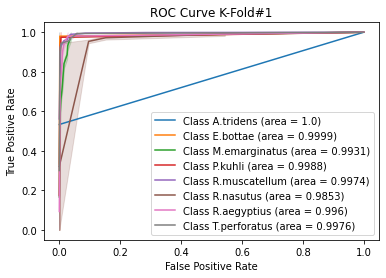

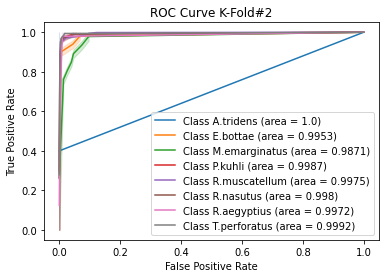

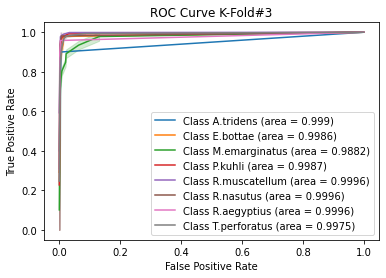

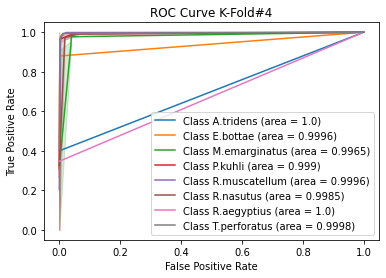

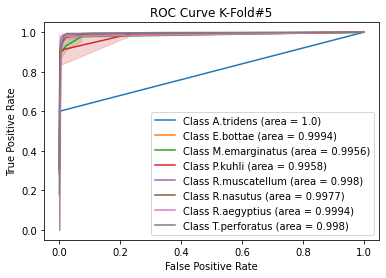

In [42]:
# Plot all K-Fold ROC curves

for i in range(n_split):
    _, axs = plt.subplots(ncols=1)
    axs.set(xlabel='False Positive Rate',ylabel='True Positive Rate', title='ROC Curve K-Fold#'+str(i+1))
    for j in range(n_classes):
        auc_val = auc(all_fpr[i][j], all_tpr[i][j])
        auc_val = np.around(auc_val,4)
        sns.lineplot(x=all_fpr[i][j],y=all_tpr[i][j],ax=axs, label='Class '+ getSpecies(j) +' (area = ' + str(auc_val) + ')', legend='brief')
        

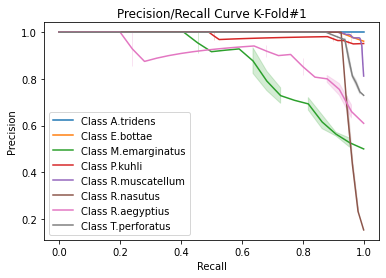

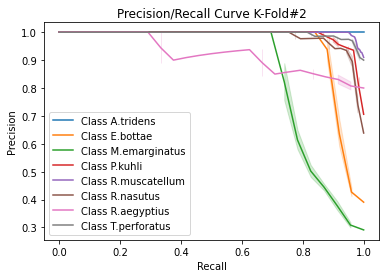

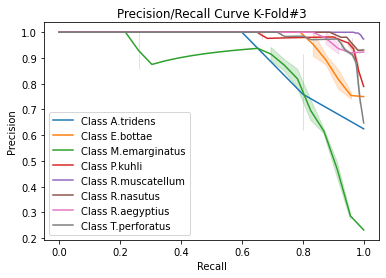

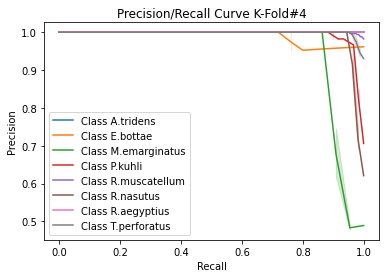

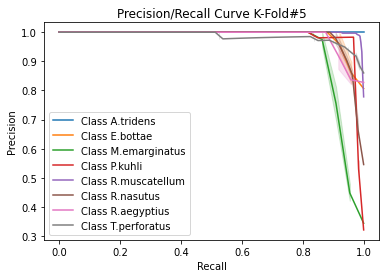

In [43]:
#Plot all K-Fold Precision/Recall curves
for i in range(n_split):
    _, axs = plt.subplots(ncols=1)
    axs.set(xlabel='Recall',ylabel='Precision', title='Precision/Recall Curve K-Fold#'+str(i+1))
    for j in range(n_classes):
        sns.lineplot(x=all_recall[i][j],y=all_precision[i][j],ax=axs, label='Class '+ getSpecies(j), legend='brief')

Confusion Matrix K-Fold #1

[[  5   0   0   0   0   0   0   0]
 [  0  24   0   0   0   0   1   0]
 [  0   1  14   0   0   0   6   1]
 [  0   0   0  58   0   1   0   0]
 [  0   0   2   1 329   1   0   0]
 [  0   0   0   1   0  51   2   0]
 [  0   0   0   1   0   0  24   0]
 [  0   0   0   0   8   0   1  72]]


Confusion Matrix K-Fold #2

[[  5   0   0   0   0   0   0   0]
 [  0  23   0   0   1   1   0   0]
 [  0   0  16   1   3   0   3   0]
 [  0   0   0  55   2   2   0   1]
 [  0   3   0   0 325   0   4   1]
 [  0   0   0   1   3  49   0   0]
 [  0   0   0   0   1   0  23   0]
 [  0   0   0   0   4   0   0  77]]


Confusion Matrix K-Fold #3

[[  4   0   0   0   0   0   1   0]
 [  0  20   0   0   3   1   0   0]
 [  0   1  17   1   0   0   1   3]
 [  0   0   0  57   1   1   0   1]
 [  0   0   0   0 332   0   0   1]
 [  0   0   0   2   0  52   0   0]
 [  0   0   0   0   0   0  24   0]
 [  0   0   2   0   3   0   1  75]]


Confusion Matrix K-Fold #4

[[  5   0   0   0   0   0   0   0]
 [  

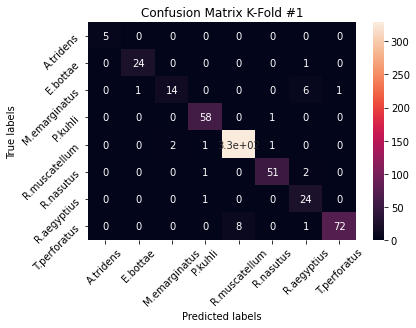

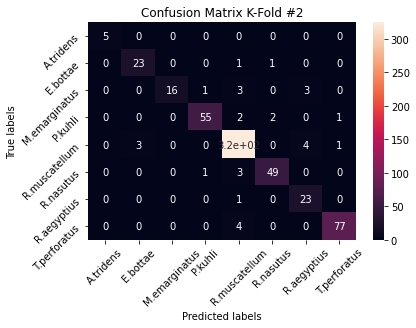

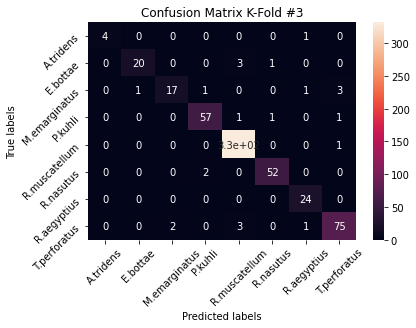

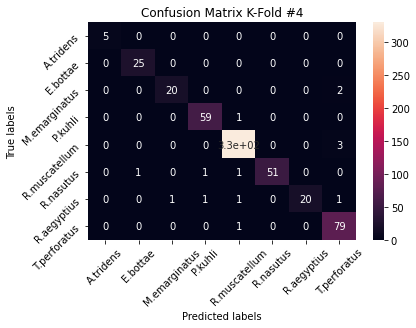

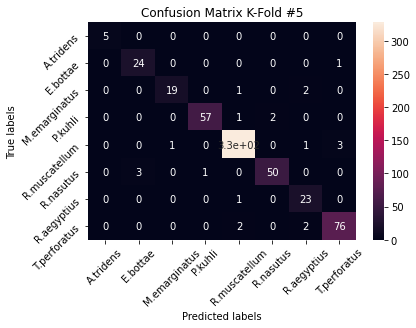

In [44]:
## Plot all K-Fold confusion matrices
import numpy as np
import matplotlib.pylab as pl
import matplotlib.gridspec as gridspec
from matplotlib import pyplot as plt

# Create 1X 5 sub plots
# gs = gridspec.GridSpec(1,n_split)
figs=[]
for i in range(n_split):
    figs.append(plt.figure())
    
for i in range(n_split):
    print('Confusion Matrix K-Fold #'+ str(i+1)+"\n")
    print(all_cm[i])
    print("\n")
    
    ax=figs[i].add_subplot()
    sns.heatmap(all_cm[i], annot=True, ax = ax); #annot=True to annotate cells

    
    # labels, title and ticks
    ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
    ax.set_title('Confusion Matrix K-Fold #'+ str(i+1)); 
    ax.xaxis.set_ticklabels(labels,rotation=45); ax.yaxis.set_ticklabels(labels,rotation=45);

sum of all confuion matrices
 [[  24    0    0    0    0    0    1    0]
 [   0  116    0    0    4    2    1    1]
 [   0    2   86    2    4    0   12    6]
 [   0    0    0  286    5    6    0    2]
 [   0    3    3    1 1644    1    5    8]
 [   0    4    0    6    4  253    2    0]
 [   0    0    1    2    3    0  114    1]
 [   0    0    2    0   18    0    4  379]]

average of all confuion matrices
 [[  4   0   0   0   0   0   0   0]
 [  0  23   0   0   0   0   0   0]
 [  0   0  17   0   0   0   2   1]
 [  0   0   0  57   1   1   0   0]
 [  0   0   0   0 328   0   1   1]
 [  0   0   0   1   0  50   0   0]
 [  0   0   0   0   0   0  22   0]
 [  0   0   0   0   3   0   0  75]]


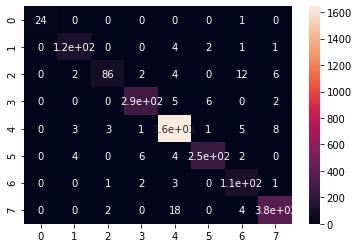

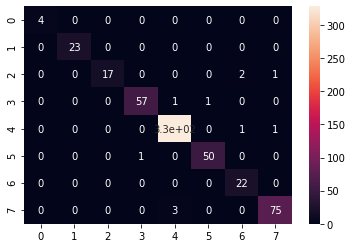

In [45]:
## plot macro cm

sum_all_cm=np.zeros((n_classes,n_classes)).astype('int64')
for i in range(n_split):
    sum_all_cm+=all_cm[i]
    
    
#plot 
figs=[]
for i in range(2):
    figs.append(plt.figure())
       
print("sum of all confuion matrices\n",sum_all_cm)
ax=figs[0].add_subplot()
sns.heatmap(sum_all_cm, annot=True, ax = ax);

avg_all_cm=np.divide(sum_all_cm,n_split).astype('int64')
print("\naverage of all confuion matrices\n",avg_all_cm)
ax=figs[1].add_subplot()
sns.heatmap(avg_all_cm, annot=True, ax = ax);

[[0.96 0.   0.   0.   0.   0.   0.04 0.  ]
 [0.   0.94 0.   0.   0.03 0.02 0.01 0.01]
 [0.   0.02 0.77 0.02 0.04 0.   0.11 0.05]
 [0.   0.   0.   0.96 0.02 0.02 0.   0.01]
 [0.   0.   0.   0.   0.99 0.   0.   0.  ]
 [0.   0.01 0.   0.02 0.01 0.94 0.01 0.  ]
 [0.   0.   0.01 0.02 0.02 0.   0.94 0.01]
 [0.   0.   0.   0.   0.04 0.   0.01 0.94]]


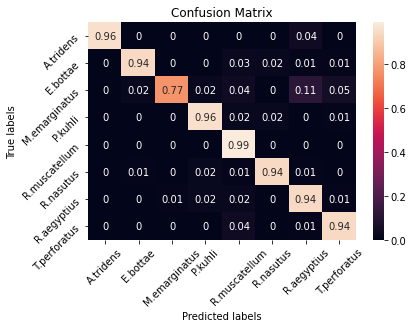

In [46]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


cm= sum_all_cm/ sum_all_cm.astype(np.float).sum(axis=1,keepdims = True)
cm = (np.around(cm,2))
print(cm)


labels = ['A.tridens','E.bottae','M.emarginatus','P.kuhli','R.muscatellum','R.nasutus', 'R.aegyptius', 'T.perforatus']


ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(labels,rotation=45); ax.yaxis.set_ticklabels(labels,rotation=45);

<h2>Storing/Loading history and model to file</h2>

In [23]:
#Store History
hist_df = pd.DataFrame(history.history) 
hist_json_file = 'Model2-P-bats.json' 
with open(hist_json_file, mode='w') as f:
    hist_df.to_json(f)

In [25]:
#Load History 
history_info = pd.read_json('Model2-P-bats.json')

In [26]:
##Save Model
model.save('Model2-P-bats_trained.model') #Save the model

In [27]:
## Load Model
model = tf.keras.models.load_model('Model2V2-bats_trained.model') #Re load model

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
